In [1]:
import torch
from torchinfo import summary
import torch.optim as optim
from torch.nn import MSELoss
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import models
import torch.nn.functional as nnf
import torch.nn as nn
from torchvision import transforms
from piq import psnr, ssim, brisque, LPIPS

from utils.metrics import validation_scores
from models.completion.AE256 import AE
from utils.datasets import Pokemon_SR_completion


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
num_epochs = 30
batch_size = 16
scalefactor = 8
latent_dims = [64]
channels = [32, 64, 128, 256]
in_channels = 3
base_width = 32
model = AE(in_channels=in_channels,
                          latent_dims=latent_dims,
                          channels=channels,
                          base_width=base_width
                          ).to(device)
print(model.sample(torch.randn(1, in_channels, base_width, base_width).to(device)).shape)
summary(model, input_size=[(1, in_channels, base_width, base_width), (1, in_channels, 256, 256)])

torch.Size([1, 3, 256, 256])


Layer (type:depth-idx)                   Output Shape              Param #
AE                                       [1, 3, 256, 256]          --
├─AELREncoder: 1-1                       [1, 64]                   --
│    └─Conv2d: 2-1                       [1, 32, 32, 32]           128
│    └─Conv2d: 2-2                       [1, 64, 16, 16]           32,832
│    └─Conv2d: 2-3                       [1, 128, 8, 8]            131,200
│    └─Linear: 2-4                       [1, 64]                   524,352
├─AEDecoder: 1-2                         [1, 3, 256, 256]          --
│    └─Linear: 2-5                       [1, 262144]               17,039,360
│    └─ConvTranspose2d: 2-6              [1, 128, 64, 64]          524,416
│    └─ConvTranspose2d: 2-7              [1, 64, 128, 128]         131,136
│    └─ConvTranspose2d: 2-8              [1, 32, 256, 256]         32,800
│    └─Conv2d: 2-9                       [1, 3, 256, 256]          99
Total params: 18,416,323
Trainable params: 18,41

Dataset Loaded: 655 training samples, 164 validation samples


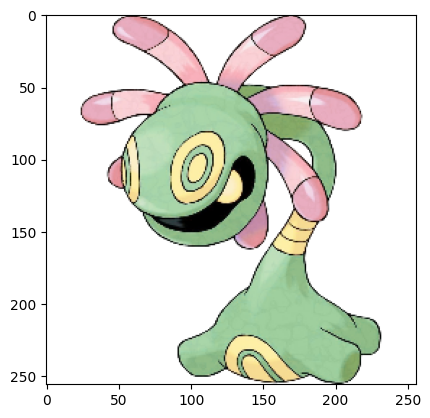

In [3]:


train_dataset = Pokemon_SR_completion(scale_factor=scalefactor, split='train', path="pokemon_white.npy")
test_dataset = Pokemon_SR_completion(scale_factor=scalefactor, split='test', path="pokemon_white.npy")

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
num_train_data = len(train_dataset)
print(f"Dataset Loaded: {len(train_dataset)} training samples, {len(test_dataset)} validation samples")
plt.imshow(train_dataset[0][0].permute(1, 2, 0).cpu().numpy())
#means = []
#stds = []
#for img in train_loader:
#    means.append(torch.mean(img[1]))
#    stds.append(torch.std(img[1]))

#mean = torch.mean(torch.tensor(means))
#std = torch.mean(torch.tensor(stds))

In [4]:
#print(mean,std)

In [5]:
# Adam opt
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss().to(device)
# Learning Rate Scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.9)

In [7]:
val_HR, val_LR, val_LR_UP = test_dataset.get_samples(100)
val_losses = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    val_total_loss = 0

    for HR, LR, LR_UP in train_loader:

        optimizer.zero_grad()

        recon_imgs = model(LR, LR_UP)

        loss = criterion(recon_imgs, HR)
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            val_recon_imgs = model(val_LR, val_LR_UP)
            val_loss = criterion(val_recon_imgs, val_HR)
            val_total_loss += val_loss.item()

        total_loss += loss.item()

    scheduler.step()

    print(f"Epoch [{epoch+1}/{num_epochs}] | Loss: {total_loss:.2f}")
    print(f"Validation Loss: {val_total_loss:.2f}")
    model.loss.append(total_loss)
    val_losses.append(val_total_loss)


Epoch [1/30] | Loss: 0.74
Validation Loss: 0.74
Epoch [2/30] | Loss: 0.73
Validation Loss: 0.73
Epoch [3/30] | Loss: 0.73
Validation Loss: 0.73
Epoch [4/30] | Loss: 0.73
Validation Loss: 0.73
Epoch [5/30] | Loss: 0.73
Validation Loss: 0.73
Epoch [6/30] | Loss: 0.73
Validation Loss: 0.73
Epoch [7/30] | Loss: 0.72
Validation Loss: 0.73
Epoch [8/30] | Loss: 0.72
Validation Loss: 0.73
Epoch [9/30] | Loss: 0.72
Validation Loss: 0.73
Epoch [10/30] | Loss: 0.72
Validation Loss: 0.73
Epoch [11/30] | Loss: 0.72
Validation Loss: 0.72
Epoch [12/30] | Loss: 0.71
Validation Loss: 0.72
Epoch [13/30] | Loss: 0.71
Validation Loss: 0.71
Epoch [14/30] | Loss: 0.70
Validation Loss: 0.69
Epoch [15/30] | Loss: 0.68
Validation Loss: 0.68
Epoch [16/30] | Loss: 0.65
Validation Loss: 0.66
Epoch [17/30] | Loss: 0.63
Validation Loss: 0.65
Epoch [18/30] | Loss: 0.60
Validation Loss: 0.63
Epoch [19/30] | Loss: 0.57
Validation Loss: 0.61
Epoch [20/30] | Loss: 0.54
Validation Loss: 0.60
Epoch [21/30] | Loss: 0.53
Va

[]

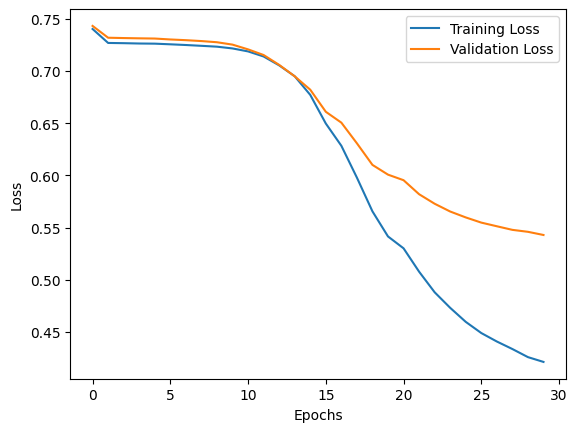

In [8]:
plt.plot(model.loss, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot()

In [34]:
HR, LR, LR_UP = test_dataset.get_samples(40)
SR = model.sample(LR)

In [35]:
def show_image(x, low_res, superres, n):

    fig, axs = plt.subplots(4, n, figsize=(20, 6))
    for i in range(n):
        #figure description above every row in the middle
        if i == 0:
            axs[0, i].set_title('Original')
            axs[1, i].set_title('Low Resolution')
            axs[2, i].set_title('Super Resolution')
            axs[3, i].set_title('Low Resolution Upscaled')

        axs[0, i].imshow(x[i].permute(1, 2, 0).detach().cpu().numpy(),)
        axs[0, i].axis('off')

        axs[1, i].imshow(low_res[i].permute(1, 2, 0).detach().cpu().numpy())
        axs[1, i].axis('off')

        axs[2, i].imshow(superres[i].permute(1, 2, 0).detach().cpu().numpy())
        axs[2, i].axis('off')

        axs[3, i].imshow(LR_UP[i].permute(1, 2, 0).detach().cpu().numpy())
        axs[3, i].axis('off')

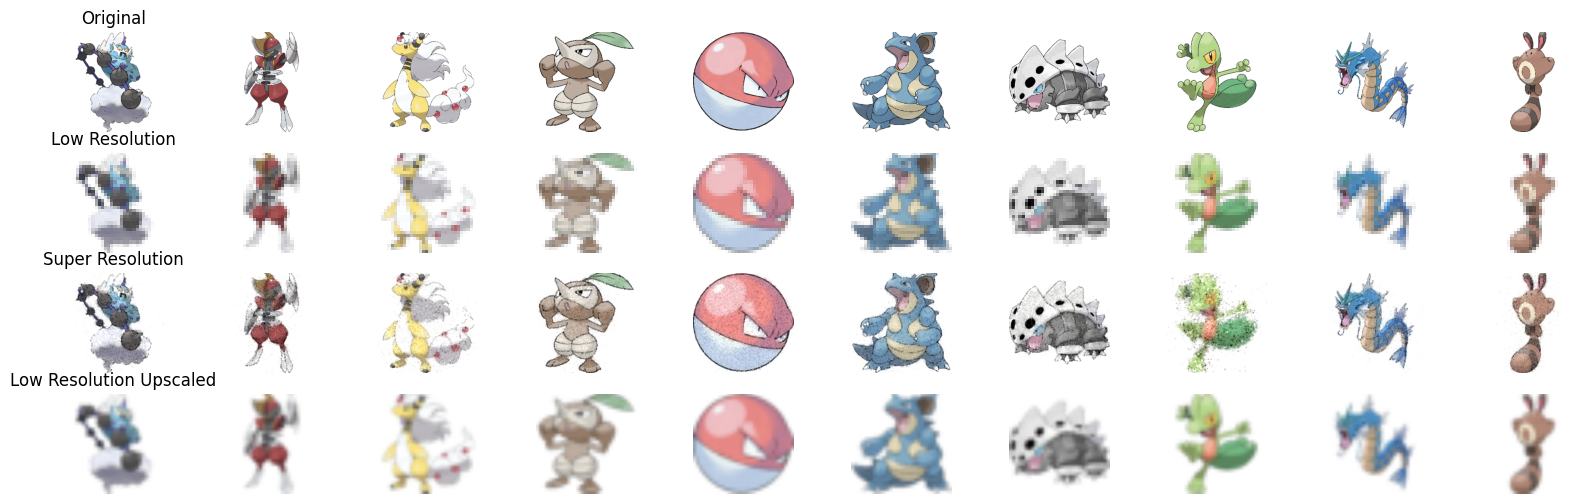

In [36]:
show_image(HR, LR, SR, 10)

In [1]:
from PIL import Image
import numpy as np
img = Image.open("fake_pikachu4.jpg").convert("RGB")

plt.imshow(img)
img_downscaled = transforms.Resize((32, 32))(transforms.ToTensor()(img)).unsqueeze(0).to(device)
plt.imshow(img_downscaled[0].permute(1, 2, 0).detach().cpu().numpy())
#img_downscaled_upscaled = transforms.Resize((256, 256))(img_downscaled)
img_superresolution = model.sample(img_downscaled)
plt.imshow(img_superresolution[0].permute(1, 2, 0).detach().cpu().numpy())
#plt.imshow(img_downscaled_upscaled [0].permute(1, 2, 0).detach().cpu().numpy())

NameError: name 'plt' is not defined

In [13]:
_, _ , psnr_val, ssim_val, lpips_val, brisque_val, psnr_consistency_val, mse_diversity_val, lpips_diversity_val = validation_scores(model, HR, LR)
print("PSNR:", psnr_val)
print("SSIM:", ssim_val)
print("LPIPS:", lpips_val)
print("BRISQUE:", brisque_val)
print("PSNR Consistency:", psnr_consistency_val)
print("MSE Diversity:", mse_diversity_val)
print("LPIPS Diversity:", lpips_diversity_val)

c:\Users\Kevin\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Kevin\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


PSNR: 19.7064208984375
SSIM: 0.6856247782707214
LPIPS: 0.35633155703544617
BRISQUE: 19.80682373046875
PSNR Consistency: 34.46604537963867
MSE Diversity: 1.8133768229872222e-16
LPIPS Diversity: 6.036300089331051e-12
